<a href="https://colab.research.google.com/github/VKarpick/Hockey-Scraper/blob/master/big_data_cup_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [37]:
!pip install pyclustering
!pip install pygam

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyclustering.cluster.gmeans import gmeans
from pygam import LogisticGAM
from pygam.terms import TermList, FactorTerm, LinearTerm, SplineTerm, TensorTerm
import requests
from scipy.stats import pearsonr
import seaborn as sns

In [39]:
url = "https://raw.githubusercontent.com/the-bucketless/nhl_rink/master/rink_plot.py"
r = requests.get(url)

with open("rink_plot.py", "w") as f:
    f.write(r.text)

from rink_plot import draw_rink

# Data

Update for preferences and add needed features.

In [40]:
df = pd.read_csv("https://raw.githubusercontent.com/bigdatacup/Big-Data-Cup-2021/main/hackathon_scouting.csv")

In [41]:
# convert columns to snake case
df.rename(columns={c: c.replace(" ", "_").lower() for c in df.columns}, inplace=True)

# column for seconds elapsed in period
df["seconds_elapsed"] = 1200 - (df.clock.str[:-3].astype(int).clip(lower=0) * 60 
                                + df.clock.str[-2:].astype(int))

# convert x,y-coordinates to resemble NHL scale
df.x_coordinate -= 100
df.y_coordinate = 42.5 - df.y_coordinate
df.x_coordinate_2 -= 100
df.y_coordinate_2 = 42.5 - df.y_coordinate_2

# symmetrize y, reflecting y_2 where necessary
df["y_coordinate_2"] *= np.sign(df.y_coordinate)
df["y_coordinate"] = np.abs(df.y_coordinate)

# convert bool columns using t/f to 1/0
df["has_traffic"] = (df.detail_3 == "t").astype(int)
df["is_one_timer"] = (df.detail_4 == "t").astype(int)

# score state
df["score_state"] = (df.home_team_goals - df.away_team_goals).clip(lower=-1, upper=1)
df.loc[df.home_team != df.team, "score_state"] *= -1

# strength state
df["strength_state"] = (df.home_team_skaters - df.away_team_skaters).clip(lower=-1, upper=1)
df.loc[df.home_team != df.team, "strength_state"] *= -1

# shots
df["is_shot"] = (df.event.isin(("Shot", "Goal"))).astype(int)

# rebounds defined as any shot within 4 seconds of the previous shot
# https://thebucketless.wordpress.com/2021/01/03/xg-model-part-2-expected-shooting-percentage/
# can't be rebound if faceoff between shots, 5000 used as dummy value
df["prev_shot_time"] = np.select([df.is_shot.shift(1) == 1, df.event == "Faceoff Win"],
                                 [df.seconds_elapsed.shift(1), 5000], default=pd.NA)
df["prev_shot_time"].fillna(method="ffill", inplace=True)
rebound_time = df.seconds_elapsed - df.prev_shot_time

# this will record some deflections as rebounds
# deflections are included in initial shot and rebounds are removed, so false positives are OK
df["is_rebound"] = ((rebound_time > -1) & (rebound_time < 5)).astype(int)

# deflected shots have two entries when deflection comes off of a shot, one for the initial shot, one for the deflection
# though shots can be listed as deflections without coming off another shot
# combine shots that are deflected into single shot
next_event = df.shift(-1)
df["is_deflected"] = ((df.is_shot == 1) & (next_event.detail_1 == "Deflection")
                      & (df.seconds_elapsed == next_event.seconds_elapsed)).astype(int)

# bool column for goals
# deflections listed as separate shots, want to record goals off of deflections as part of initial shot
df["has_deflection_goal"] = ((next_event.event == "Goal") & (df.is_deflected == 1)).astype(int)
df["is_goal"] = (df.event == "Goal") + df.has_deflection_goal

# rush chances defined as any event within 6 seconds of an entry
# https://jenlc13.wordpress.com/2016/04/13/zone-time-goals/
# can't be rush if faceoff since entry, 5000 used as dummy value
df["prev_entry_time"] = np.select([df.event == "Zone Entry", df.event == "Faceoff Win"],
                                    [df.seconds_elapsed, 5000], default=pd.NA)
df["prev_entry_time"].fillna(method="ffill", inplace=True)
df["is_rush"] = ((df.seconds_elapsed - df.prev_entry_time).between(0, 6)).astype(int)

# categorical for shot types
df["shot_type"] = np.where(df.is_shot == 1, df.detail_1, pd.NA)
df["shot_type"] = df.shot_type.astype("category").cat.codes

Rush shots vs in-zone shots

In [42]:
df_5v5 = df.loc[(df.is_shot == 1) & (df.home_team_skaters == 5) & (df.away_team_skaters == 5)]
offense_types = df_5v5.groupby(by=["is_rush"]).agg({"is_shot": "sum", "is_goal": sum})

for i in range(2):
    offense_type = ("In-zone", "Rush")[i]
    n_shots = offense_types.loc[i, "is_shot"]
    n_goals = offense_types.loc[i, "is_goal"]
    print(f"{offense_type} shots: {n_shots / df_5v5.shape[0] : .2f}")
    print(f"{offense_type} goals: {n_goals / df_5v5.is_goal.sum() : .2f}")
    print(f"{offense_type} shooting: {n_goals / n_shots : .2f}%")

In-zone shots:  0.59
In-zone goals:  0.46
In-zone shooting:  0.04%
Rush shots:  0.41
Rush goals:  0.54
Rush shooting:  0.07%


# Expected Goal Model

Create dataframe to use for expected goal model.

Only include non-rebounds from between the blue line and the goal line.

In [43]:
xg_df = df.copy().loc[(df.is_shot == 1)    # shot events
                       & (df.x_coordinate.between(25, 89))    # between blue line and goal line
                       & (df.is_rebound == 0)]    # non-rebounds (also removes deflections)

Fit GAM.  Number of splines chosen based on visual appeal of heatmap - specifically, to allow for more gradual changes in the colours, especially in the upper wings.  Lambda values were tuned offline.

In [44]:
features = ["x_coordinate", "y_coordinate", "has_traffic", "is_one_timer", "is_deflected", 
            "is_rush", "shot_type", "score_state", "strength_state"]
target = "is_goal"

terms = TermList(
    TensorTerm(0, 1, n_splines=[11, 7], lam=[0.6935219489715991, 0.01911143742976475]),    # coordinates
    LinearTerm(2, lam=0.767163252026124),    # traffic
    LinearTerm(3, lam=0.5779779868836172),    # one-timer
    LinearTerm(4, lam=0.35469784007479943),    # deflected
    LinearTerm(5, lam=0.06301660371073449),    # rush chance
    FactorTerm(6, lam=0.012669426492780637),    # shot type
    FactorTerm(7, lam=1.7292594656357347),    # score state
    FactorTerm(8, lam=27.499169976489114),    # strength state
)

xg_gam = LogisticGAM(terms=terms).fit(xg_df[features], xg_df[target])

Apply to original dataframe.

In [45]:
df["xg"] = pd.NA
df.loc[df.is_shot == 1, "xg"] = xg_gam.predict_proba(df.loc[df.is_shot == 1, features])

Function for drawing a heatmap using a GAM's partial dependence on the coordinates.

In [46]:
def heatmap(gam=None, term=0, max_x=89, min_y=0):
    if gam is None:
        gam = xg_gam

    # XX = gam.generate_X_grid(term=term, meshgrid=True)
    Xs = [np.linspace(25, max_x, 100), np.linspace(min_y, 42.5, 100)]
    XX = tuple(np.meshgrid(*Xs, indexing="ij"))
    Z = gam.partial_dependence(term=term, X=XX, meshgrid=True)

    heatmap_df = pd.DataFrame({"x": XX[0].flatten(), 
                               "y": XX[1].flatten(),
                               "weights": Z.flatten()})

    # set coordinates outside of rink to appear white
    is_in_rink = ((heatmap_df.x < 73) | (np.abs(heatmap_df.y) < 14.5)
                  | ((72 - heatmap_df.x)**2 + (14.5 - np.abs(heatmap_df.y))**2 <= 784))
    heatmap_df.loc[~is_in_rink, "weights"] = pd.NA
    heatmap_df["weights"].fillna(value=heatmap_df.weights.mean(), inplace=True)

    # standardize
    heatmap_df["weights"] = ((heatmap_df.weights - heatmap_df.weights.mean()) 
                             / heatmap_df.weights.std())

    heatmap_df.sort_values(by=["x", "y"], inplace=True)

    # color range
    # use the lower of the absolute bounds to ensure both sides of distribution show up
    vmin = max(heatmap_df.weights.min(), -heatmap_df.weights.max())
    vmax = -vmin

    ax = draw_rink(False, "ozone", None, 6)

    # if y-coordinates symmetrized, need to reflect to draw on both halves
    board_range = [-42.5, 42.5] if min_y == 0 else [42.5]
    for side_boards in board_range:
        ax.imshow(np.reshape(np.array(heatmap_df.weights), (100, 100)), 
                  cmap="bwr", origin="lower", zorder=-0.5, vmin=vmin, vmax=vmax,
                  extent=[min_y, side_boards, 25, XX[0].max()])

Text(0.5, 1.0, 'Expected goals')

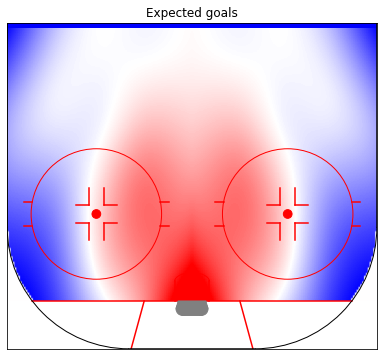

In [47]:
heatmap()
plt.title("Expected goals")

# Pass xG

Only considering non-rush direct ozone passes at 5-on-5.

Data was examined and no passing events between a shot and its rebound were found - no rebound attempts should be included.

In [48]:
passing_df = df.copy()

# change in x
passing_df["dx"] = passing_df.x_coordinate_2 - passing_df.x_coordinate

# change in y
passing_df["dy"] = passing_df.y_coordinate_2 - passing_df.y_coordinate

# which zone the play takes place in
passing_df["zone"] = np.select([passing_df.x_coordinate < -26, 
                                passing_df.event == "Zone Entry", 
                                passing_df.x_coordinate > 24],
                               ["d", "n", "o"], default="n")

# bool for direct/indirect passes
passing_df["is_direct"] = (passing_df.detail_1 == "Direct").astype(int)

# bool for complete/incomplete passes
passing_df["is_complete"] = (passing_df.event == "Play").astype(int)

# bool for indicating if a team has retained possession of the puck
# will include rebounds, but these won't be included when filling
passing_df["is_retained"] = (passing_df.event.isin(("Play", "Shot"))
                             | ((passing_df.event == "Zone Entry") 
                                & (passing_df.detail_1 != "Dumped"))).astype(int)

# zone exits
# successful zone exits require team to maintain possession while exiting defensive zone
# will ignore defensive exits for carries off of faceoff wins, these aren't relevant to this project
passing_df["next_zone"] = passing_df.zone.shift(-1).fillna(passing_df.zone.iloc[-1])
team_change = passing_df.team != passing_df.team.shift(-1)
reverse_zone = {"o": "d", "d": "o", "n": "n"}    # reverse zone when opponent has puck
passing_df.loc[team_change, "next_zone"] = passing_df.next_zone.map(reverse_zone)
pass_out = (passing_df.event == "Play") & (passing_df.x_coordinate_2 > -25)
carry_out = ((passing_df.event.isin(("Play", "Takeaway", "Puck Recovery"))) 
             & (passing_df.next_zone != "d"))
dzone_exit = ((passing_df.zone == "d") & ((pass_out) | (carry_out)))
passing_df["is_zone_exit"] = (dzone_exit).astype(int)

# bool indicating if a play directly or indirectly leads to a successful zone exit
passing_df["has_exit"] = np.select([passing_df.is_zone_exit == 1, passing_df.is_retained == 0], 
                                   [1, 0], default=pd.NA)
passing_df.has_exit.fillna(method="bfill", inplace=True)

# successful zone entries with possession
passing_df["is_zone_entry"] = ((passing_df.event == "Zone Entry") 
                               & (passing_df.detail_1 != "Dumped")).astype(int)

# bool indicating if a play directly or indirectly leads to a successful zone entry
passing_df["has_entry"] = np.select([passing_df.is_zone_entry == 1, passing_df.is_retained == 0], 
                                    [1, 0], default=pd.NA)
passing_df.has_entry.fillna(method="bfill", inplace=True)

# bool indicating if a play directly or indirectly leads to a shot
passing_df["has_shot"] = np.select([passing_df.is_shot == 1, passing_df.is_retained == 0], 
                                   [1, 0], default=pd.NA)
passing_df.has_shot.fillna(method="bfill", inplace=True)

# bool indicating if a play directly or indirectly leads to a goal
passing_df["has_goal"] = np.select([passing_df.is_goal == 1, passing_df.is_retained == 0],
                                   [1, 0], default=pd.NA)
passing_df.has_goal.fillna(method="bfill", inplace=True)

# amount of xg pass eventually leads to
passing_df["sequence_xg"] = np.select([~passing_df.xg.isna(), passing_df.is_retained == 0], 
                                      [passing_df.xg, 0.0], default=pd.NA)
passing_df.sequence_xg.fillna(method="bfill", inplace=True)

# bool if incomplete play leads to other team getting possession
passing_df["turnover"] = ((passing_df.is_complete == 0) 
                          & (passing_df.event.shift(-1).isin(("Puck Recovery", "Takeaway")))
                          & (passing_df.team != passing_df.team.shift(-1))).astype(int)

# exit off of turnover
passing_df["turnover_has_exit"] = ((passing_df.turnover == 1) 
                                   & (passing_df.has_exit.shift(-2) == 1)).astype(int)

# entry off of turnover
passing_df["turnover_has_entry"] = ((passing_df.turnover == 1) 
                                    & (passing_df.has_entry.shift(-2) == 1)).astype(int)

# shot off of turnover
passing_df["turnover_has_shot"] = ((passing_df.turnover == 1) 
                                   & (passing_df.has_shot.shift(-2) == 1)).astype(int)

# xg off of turnover
passing_df["turnover_sequence_xg"] = passing_df.turnover * passing_df.sequence_xg.shift(-2)

In [49]:
# subset to only include non-rush direct 5-on-5 passes from the ozone to the ozone
passing_df = passing_df.loc[(passing_df.event.isin(("Play", "Incomplete Play"))) 
                            & (passing_df.is_rush == 0) & (passing_df.detail_1 == "Direct")
                            & (passing_df.home_team_skaters == 5) & (passing_df.away_team_skaters == 5)
                            & (passing_df.x_coordinate > 24) & (passing_df.x_coordinate_2 > 24)]

Fit GAM for passing model.  Numbers of splines for coordinate terms chosen based on heatmap.  Numbers of splines for change in coordinate features and lambda values for all features were tuned offline.

In [50]:
features = ["x_coordinate", "y_coordinate", "x_coordinate_2", "y_coordinate_2", "dx", "dy"]
target = "has_goal"

terms = TermList(
    TensorTerm(0, 1, n_splines=[11, 10], lam=[0.8830277560582404, 0.8830277560582404]),
    TensorTerm(2, 3, n_splines=[14, 12], lam=[3.9541554928514566, 3.9541554928514566]),
    SplineTerm(4, n_splines=9, lam=2.3195325645404243),
    SplineTerm(5, n_splines=7, lam=52.974125915574504)
)

passing_gam = LogisticGAM(terms=terms).fit(passing_df[features], passing_df[target])

Add to dataframe.

In [51]:
passing_df["passing_xg"] = passing_gam.predict_proba(passing_df[features])

# Partial Dependence

Text(0.5, 1.0, 'Release coordinate')

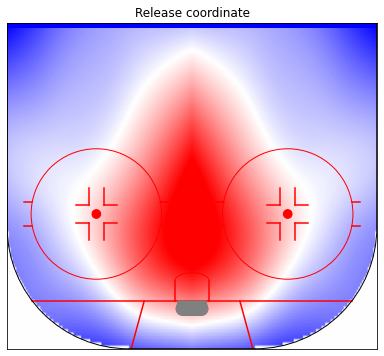

In [52]:
heatmap(passing_gam, 0, 100, 0)
plt.title("Release coordinate")

Text(0.5, 1.0, 'Target coordinate')

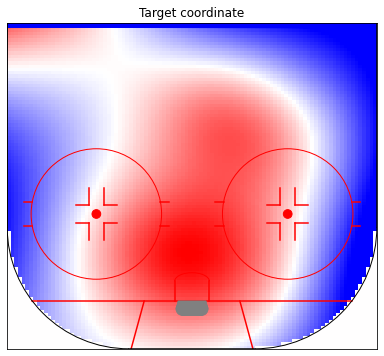

In [53]:
heatmap(passing_gam, 1, 100, -42.5)
plt.title("Target coordinate")

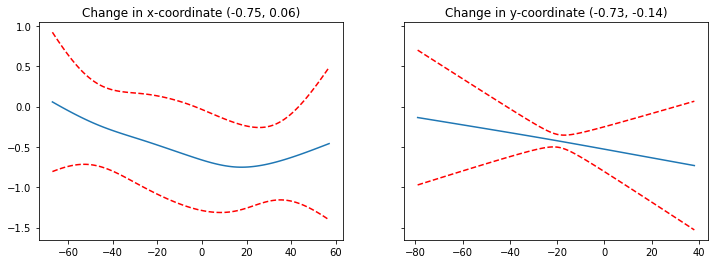

In [54]:
titles = ["Change in x-coordinate", "Change in y-coordinate"]

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

for i, term in enumerate(passing_gam.terms):
    if term.isintercept or term.istensor:
        continue

    XX = passing_gam.generate_X_grid(term=i)

    pdep, confi = passing_gam.partial_dependence(term=i, X=XX, width=0.95)

    ax = axs[i % 2]

    ax.plot(XX[:, term.feature], pdep)
    ax.plot(XX[:, term.feature], confi, c='r', ls='--')
    ax.title.set_text(f"{titles[i % 2]} ({pdep.min():.2f}, {pdep.max():.2f})")

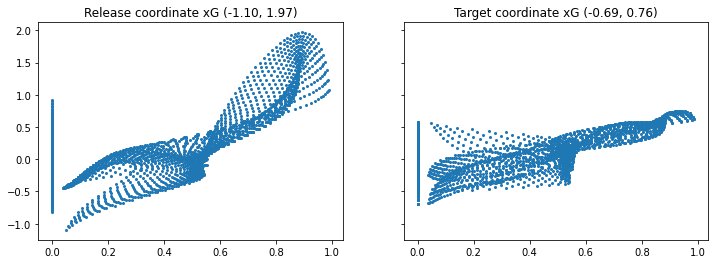

In [55]:
titles = ["Release coordinate xG", "Target coordinate xG"]

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

for i in range(2):
    min_y = [0, -42.5][i]
    Xs = [np.linspace(25, 100), np.linspace(min_y, 42.5)]
    XX = tuple(np.meshgrid(*Xs, indexing="ij"))
    pdep = passing_gam.partial_dependence(term=i, X=XX, meshgrid=True).flatten()

    XX = (XX[0], np.abs(XX[1]))
    coord_xg = xg_gam.partial_dependence(term=0, X=XX, meshgrid=True)
    coord_xg = xg_gam.link.mu(coord_xg, xg_gam.distribution).flatten()
    coord_xg[XX[0].flatten() > 89] = 0.0
    
    ax = axs[i]

    ax.plot(coord_xg, pdep, "o", markersize=2)
    ax.title.set_text(f"{titles[i % 2]} ({pdep.min():.2f}, {pdep.max():.2f})")

# Correlations

In [56]:
def regplot(ax, x, y, xlabel, ylabel):
    r, p = pearsonr(x, y)
    ax = sns.regplot(x=x, y=y, ax=ax, line_kws={"color": "orange"})
    ax.set(xlabel=xlabel, ylabel=ylabel)
    ax.text(.45, .8, f"r = {r:.2f}\np = {p:.2f}", transform=ax.transAxes)

In [57]:
def kdeplot(ax, x, y, xlabel, ylabel):
    r, p = pearsonr(passing_df[x], passing_df[y])
    ax = sns.kdeplot(data=passing_df, x=x, hue=y, multiple="fill", ax=ax)
    ax.set(xlabel=xlabel)
    ax.legend(title=ylabel, labels=["True", "False"])
    ax.text(.45, .8, f"r = {r:.2f}\np = {p:.2f}", transform=ax.transAxes)

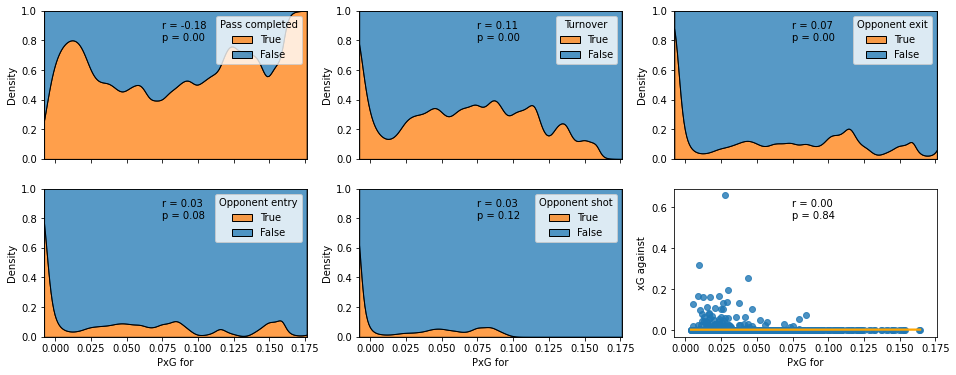

In [58]:
fig, axs = plt.subplots(2, 3, figsize=(16, 6), sharex=True)
kdeplot(axs[0, 0], "passing_xg", "is_complete", "PxG for", "Pass completed")
kdeplot(axs[0, 1], "passing_xg", "turnover", "PxG for", "Turnover")
kdeplot(axs[0, 2], "passing_xg", "turnover_has_exit", "PxG for", "Opponent exit")
kdeplot(axs[1, 0], "passing_xg", "turnover_has_entry", "PxG for", "Opponent entry")
kdeplot(axs[1, 1], "passing_xg", "turnover_has_shot", "PxG for", "Opponent shot")
regplot(axs[1, 2], passing_df.passing_xg, passing_df.turnover_sequence_xg, "PxG for", "xG against")

# Pass Clusters

Find and record clusters using g-means.

In [59]:
coord_columns = ["x_coordinate", "y_coordinate", "x_coordinate_2", "y_coordinate_2"]
X = np.array(passing_df[coord_columns])

gm = gmeans(X, random_state=42).process()
passing_df["cluster"] = gm.predict(X)

In [60]:
centers = gm.get_centers()
len(centers)

105

Group passes by cluster.

In [61]:
passing_df["n_passes"] = 1

column_names_in_common = ["has_exit", "has_entry", "has_shot", "sequence_xg"]
columns = ["n_passes", "is_complete", *column_names_in_common, "passing_xg",
           "turnover", *[f"turnover_{c}" for c in column_names_in_common]]

# raw totals
passes = passing_df.groupby(by="cluster")[columns].sum()

# percentages
for column in columns[1:]:
    passes[f"{column}_pct"] = passes[column] / passes.n_passes

Retain only the top 80%.

In [62]:
common_passes = passes.sort_values(by="n_passes", ascending=False)
common_passes.head()

,n_passes,is_complete,has_exit,has_entry,has_shot,sequence_xg,passing_xg,turnover,turnover_has_exit,turnover_has_entry,turnover_has_shot,turnover_sequence_xg,is_complete_pct,has_exit_pct,has_entry_pct,has_shot_pct,sequence_xg_pct,passing_xg_pct,turnover_pct,turnover_has_exit_pct,turnover_has_entry_pct,turnover_has_shot_pct,turnover_sequence_xg_pct
cluster,,,,,,,,,,,,,,,,,,,,,,,
56,97,84,5,0,66,1.345443,1.366038,7,0,4,4,0.162663,0.865979,0.051546,0.0,0.680412,0.013871,0.014083,0.072165,0.000000,0.041237,0.041237,0.001677
51,69,47,4,0,26,0.662576,0.458565,14,7,3,0,0.000000,0.681159,0.057971,0.0,0.376812,0.009603,0.006646,0.202899,0.101449,0.043478,0.000000,0.000000
57,64,63,1,0,50,0.781710,1.114303,1,0,0,0,0.000000,0.984375,0.015625,0.0,0.781250,0.012214,0.017411,0.015625,0.000000,0.000000,0.000000,0.000000
82,62,55,4,0,40,0.551941,0.765156,4,0,1,0,0.000000,0.887097,0.064516,0.0,0.645161,0.008902,0.012341,0.064516,0.000000,0.016129,0.000000,0.000000
75,60,53,2,0,38,0.589816,0.783080,2,0,1,0,0.000000,0.883333,0.033333,0.0,0.633333,0.009830,0.013051,0.033333,0.000000,0.016667,0.000000,0.000000


In [63]:
common_passes.tail()

,n_passes,is_complete,has_exit,has_entry,has_shot,sequence_xg,passing_xg,turnover,turnover_has_exit,turnover_has_entry,turnover_has_shot,turnover_sequence_xg,is_complete_pct,has_exit_pct,has_entry_pct,has_shot_pct,sequence_xg_pct,passing_xg_pct,turnover_pct,turnover_has_exit_pct,turnover_has_entry_pct,turnover_has_shot_pct,turnover_sequence_xg_pct
cluster,,,,,,,,,,,,,,,,,,,,,,,
103,12,7,0,0,6,0.172137,0.322355,2,0,1,0,0.0,0.583333,0.000000,0.0,0.500000,0.014345,0.026863,0.166667,0.000000,0.083333,0.0,0.0
104,12,6,1,0,6,0.098816,0.451359,3,1,0,0,0.0,0.500000,0.083333,0.0,0.500000,0.008235,0.037613,0.250000,0.083333,0.000000,0.0,0.0
92,11,10,0,0,9,0.196505,0.304588,1,0,0,0,0.0,0.909091,0.000000,0.0,0.818182,0.017864,0.027690,0.090909,0.000000,0.000000,0.0,0.0
23,8,6,0,0,3,0.245945,0.129193,0,0,0,0,0.0,0.750000,0.000000,0.0,0.375000,0.030743,0.016149,0.000000,0.000000,0.000000,0.0,0.0
79,4,3,0,0,3,0.018643,0.257593,1,0,0,0,0.0,0.750000,0.000000,0.0,0.750000,0.004661,0.064398,0.250000,0.000000,0.000000,0.0,0.0


In [64]:
thr = passes.n_passes.quantile(0.20)
print(thr)

20.0


In [65]:
common_passes = common_passes[common_passes.n_passes >= thr]

In [66]:
passes.shape, common_passes.shape

((105, 23), (87, 23))

# Visualize best and worst passes.

In [67]:
def draw_passes(coordinates, color, reflect_y=False):
    for i, coord in enumerate(coordinates):
        # vertical rink plot requires reversal of x,y-coordinates
        factor = -1 if reflect_y else 1
        plt.arrow(coord[1] * factor, coord[0], 
                    (coord[3] - coord[1]) * factor, coord[2] - coord[0], 
                    length_includes_head=True, head_width=1.2,
                    color=color, zorder=2, linewidth=1)
            

def best_worst_passes(column, top_quantile=0.85, bottom_quantile=0.15, reflect_y=None):
    sorted_passes = common_passes.copy().sort_values(by=column, ascending=False)
    top_passes = sorted_passes.loc[sorted_passes[column] >= sorted_passes[column].quantile(top_quantile)]
    bottom_passes = sorted_passes.loc[sorted_passes[column] <= sorted_passes[column].quantile(bottom_quantile)]

    heatmap()
    if top_quantile < 1:
        draw_passes([centers[i] for i in list(top_passes.index)], "yellow", reflect_y is True)
    if bottom_quantile > 0:
        draw_passes([centers[i] for i in list(bottom_passes.index)], "black", reflect_y is not False)

Text(0.5, 1.0, 'All cluster centers')

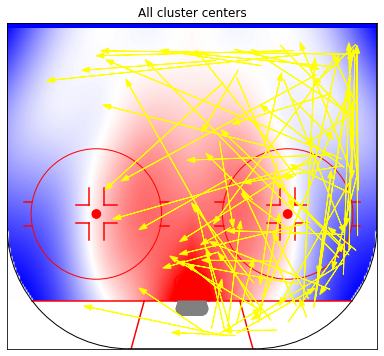

In [68]:
best_worst_passes("n_passes", 0, 0)
plt.title("All cluster centers")

Text(0.5, 1.0, 'Royal road passes leading to goals')

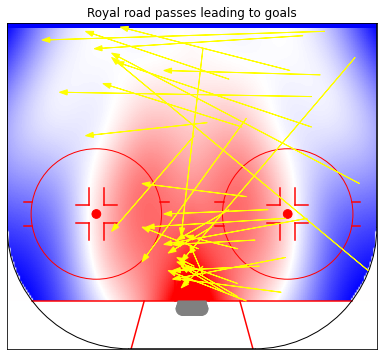

In [69]:
royal_road = passing_df.loc[(passing_df.has_goal == True) 
                            & ((np.sign(passing_df.y_coordinate) != np.sign(passing_df.y_coordinate_2)))]
heatmap()
draw_passes(np.array(royal_road[coord_columns]), "yellow")
plt.title("Royal road passes leading to goals")

Text(0.5, 1.0, 'Passes by completion rate')

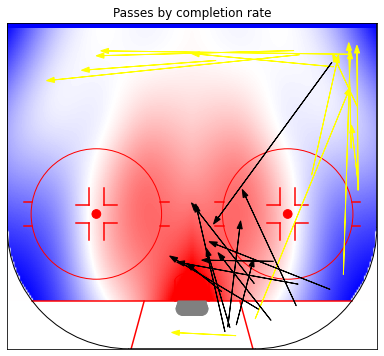

In [70]:
best_worst_passes("is_complete_pct", reflect_y=False)
plt.title("Passes by completion rate")

Text(0.5, 1.0, 'Passes by turnover rate')

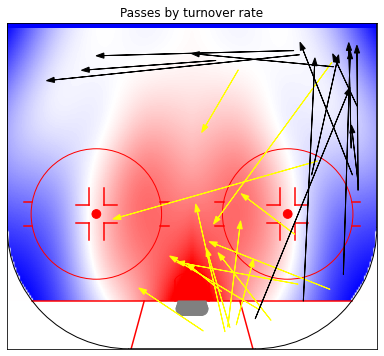

In [71]:
best_worst_passes("turnover_pct", reflect_y=False)
plt.title("Passes by turnover rate")

Text(0.5, 1.0, 'Passes by PxG')

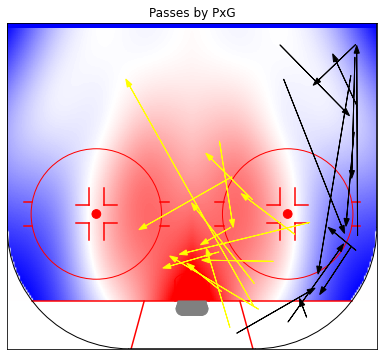

In [72]:
best_worst_passes("passing_xg_pct", reflect_y=False)
plt.title("Passes by PxG")